### Прогноз размещения на площадке (сумма по размещению за 29 месяцев) 

In [7]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [9]:
data = pd.read_excel('Total29.xlsx')
data.head()

,Total29,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M27,M28,M29,M30,M31,M32,M33,M34,M35,M36
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,620,674,1065,1067,0,0,0
1,261,1,23,43,51,26,44,35,35,35,...,42,44,23,45,32,59,17,0,0,0
2,593,0,25,13,35,33,18,22,26,18,...,19,8,23,22,31,16,10,0,0,0
3,23,5,72,55,53,56,67,49,69,52,...,134,116,117,133,87,94,53,0,0,0
4,238,0,16,5,0,4,12,6,9,2,...,19,8,4,2,3,15,3,0,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 37 columns):
Total29    684 non-null int64
M1         684 non-null int64
M2         684 non-null int64
M3         684 non-null int64
M4         684 non-null int64
M5         684 non-null int64
M6         684 non-null int64
M7         684 non-null int64
M8         684 non-null int64
M9         684 non-null int64
M10        684 non-null int64
M11        684 non-null int64
M12        684 non-null int64
M13        684 non-null int64
M14        684 non-null int64
M15        684 non-null int64
M16        684 non-null int64
M17        684 non-null int64
M18        684 non-null int64
M19        684 non-null int64
M20        684 non-null int64
M21        684 non-null int64
M22        684 non-null int64
M23        684 non-null int64
M24        684 non-null int64
M25        684 non-null int64
M26        684 non-null int64
M27        684 non-null int64
M28        684 non-null int64
M29        684 non-null i

In [11]:
melt = data.melt(id_vars='Total29', var_name='Month', value_name='Proc')

melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Total29', 'Month'])
melt.head()

,Total29,Month,Proc
0,0,1,0
684,0,2,0
1368,0,3,0
2052,0,4,0
2736,0,5,0


In [12]:
melt2 =  melt.copy()
melt2['Last_Month_Proc'] = melt2.groupby(['Total29'])['Proc'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['Total29'])['Last_Month_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,Total29,Month,Proc,Last_Month_Proc,Last_Month_Diff
1368,0,3,0,0.0,0.0
2052,0,4,0,0.0,0.0
2736,0,5,0,0.0,0.0
3420,0,6,0,0.0,0.0
4104,0,7,0,0.0,0.0


In [13]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23256 entries, 1368 to 24063
Data columns (total 5 columns):
Total29            23256 non-null int64
Month              23256 non-null int32
Proc               23256 non-null int64
Last_Month_Proc    23256 non-null float64
Last_Month_Diff    23256 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 999.3 KB


In [14]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [15]:
import copy

In [16]:
procedures = []
for Month in range(0,30):
    val=melt2[melt2['Month'] == Month]
    total=sum(val['Proc'])
    procedures.append(total)

In [17]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    yts=val['Proc']
    
    p = val['Last_Month_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))

Month 30 - Error 0.66130, Real Total 44141.0 - Predict Total 43152.0, Abs Error 989.0
Month 31 - Error 0.78531, Real Total 32367.0 - Predict Total 44141.0, Abs Error 11774.0
Month 32 - Error 0.75503, Real Total 40749.0 - Predict Total 32367.0, Abs Error 8382.0
Mean Error = 0.73388
Mean Abs Error = 7048.33333
Wall time: 12 ms


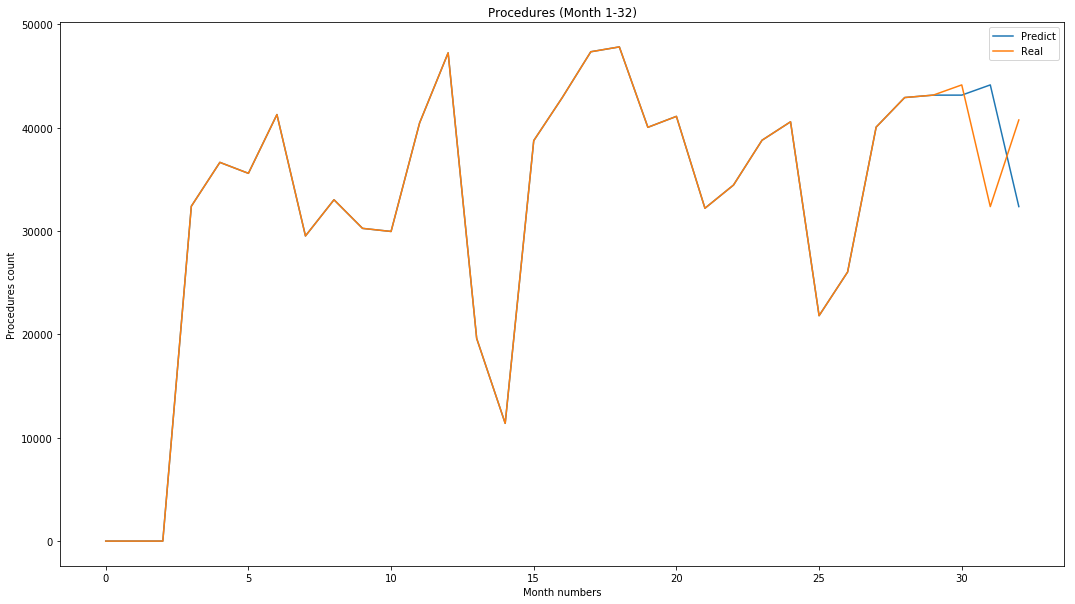

In [18]:

plt.plot(predict_ProcB)
plt.plot(ProcB)
plt.title('Procedures (Month 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

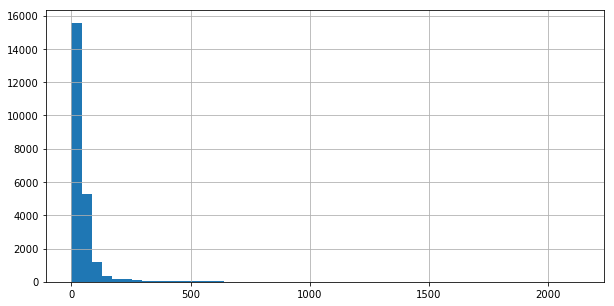

In [19]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [20]:
%%time
mean_error2 = []
total_error2 = []
Proc2 = copy.copy(procedures)
predict_Proc2 = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_error2.append(error)
    total_error2.append(abs_error)
    Proc2.append(total_yts)
    predict_Proc2.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_error2))
print('Mean Abs Error = %.5f' % np.mean(total_error2))

Month 30 - Error 0.88244, Real Total 44141.0 - Predict Total 41259.0, Abs Error 2882.0
Month 31 - Error 1.08715, Real Total 32367.0 - Predict Total 42436.3, Abs Error 10069.3
Month 32 - Error 0.93408, Real Total 40749.0 - Predict Total 33364.9, Abs Error 7384.1
Mean Error = 0.96789
Mean Abs Error = 6778.48225
Wall time: 145 ms


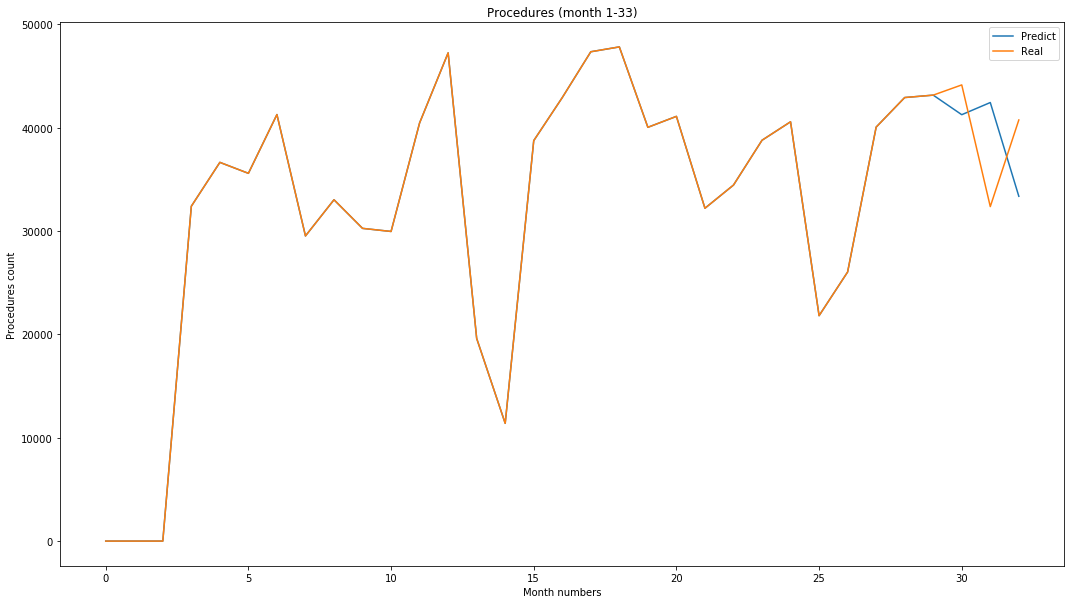

In [21]:

plt.plot(predict_Proc2)
plt.plot(Proc2)
plt.title('Procedures (month 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [22]:
%%time
mean_errorRF2 = []
total_errorRF2 = []
ProcRF2 = copy.copy(procedures)
predict_ProcRF2 = copy.copy(procedures)
for Month in range(30,33):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF2.append(error)
    total_errorRF2.append(abs_error)
    ProcRF2.append(total_yts)
    predict_ProcRF2.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF2))

Month 30 - Error 0.65198, Real Total 44141.0 - Predict Total 44242.2, Abs Error 101.2
Month 31 - Error 0.85838, Real Total 32367.0 - Predict Total 43924.5, Abs Error 11557.5
Month 32 - Error 0.66952, Real Total 40749.0 - Predict Total 32972.6, Abs Error 7776.4
Mean Error = 0.72663
Mean Abs Error = 6478.37033
Wall time: 37.6 s


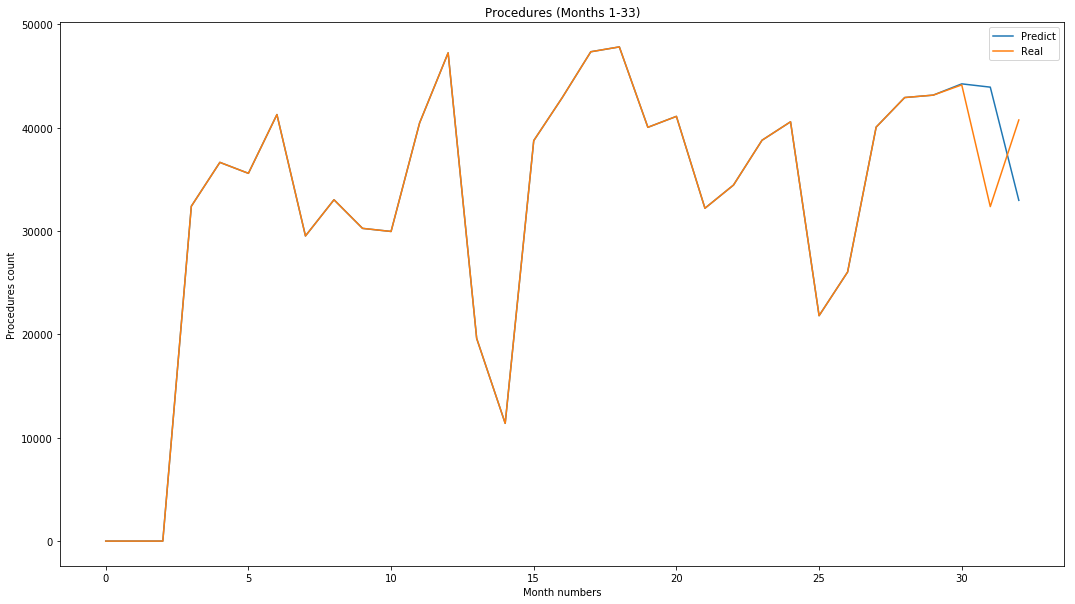

In [23]:

plt.plot(predict_ProcRF2)
#plt.plot(ProcRF2)
plt.plot(ProcB)
plt.title('Procedures (Months 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [24]:
melt3 = melt.copy()
melt3['Last_Month_Proc'] = melt3.groupby(['Total29'])['Proc'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['Total29'])['Last_Month_Proc'].diff()
melt3['Last-1_Month_Proc'] = melt3.groupby(['Total29'])['Proc'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['Total29'])['Last-1_Month_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,Total29,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff
2052,0,4,0,0.0,0.0,0.0,0.0
2736,0,5,0,0.0,0.0,0.0,0.0
3420,0,6,0,0.0,0.0,0.0,0.0
4104,0,7,0,0.0,0.0,0.0,0.0
4788,0,8,0,0.0,0.0,0.0,0.0


In [25]:
%%time
mean_errorRF3 = []
total_errorRF3 = []
ProcRF3 = copy.copy(procedures)
predict_ProcRF3 = copy.copy(procedures)
for Month in range(30,33):
    train = melt3[melt3['Month'] < Month]
    val = melt3[melt3['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF3.append(error)
    total_errorRF3.append(abs_error)
    ProcRF3.append(total_yts)
    predict_ProcRF3.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF3))

Month 30 - Error 0.65118, Real Total 44141.0 - Predict Total 45140.0, Abs Error 999.0
Month 31 - Error 0.86532, Real Total 32367.0 - Predict Total 44333.6, Abs Error 11966.6
Month 32 - Error 0.67047, Real Total 40749.0 - Predict Total 33905.4, Abs Error 6843.6
Mean Error = 0.72899
Mean Abs Error = 6603.06333
Wall time: 53.8 s


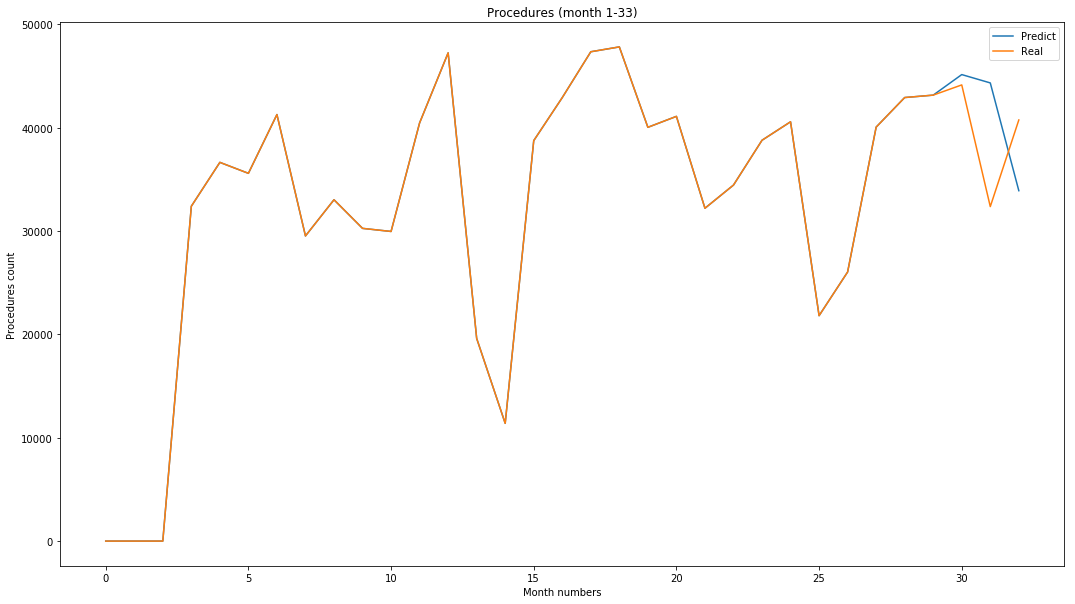

In [26]:

plt.plot(predict_ProcRF3)
plt.plot(ProcRF3)
plt.title('Procedures (month 1-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [27]:
melt4 = melt.copy()
melt4['Last_Month_Proc'] = melt4.groupby(['Total29'])['Proc'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['Total29'])['Last_Month_Proc'].diff()
melt4['Last-1_Month_Proc'] = melt4.groupby(['Total29'])['Proc'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['Total29'])['Last-1_Month_Proc'].diff()
melt4['Last-2_Month_Proc'] = melt4.groupby(['Total29'])['Proc'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['Total29'])['Last-2_Month_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,Total29,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff,Last-2_Month_Proc,Last-2_Month_Diff
2736,0,5,0,0.0,0.0,0.0,0.0,0.0,0.0
3420,0,6,0,0.0,0.0,0.0,0.0,0.0,0.0
4104,0,7,0,0.0,0.0,0.0,0.0,0.0,0.0
4788,0,8,0,0.0,0.0,0.0,0.0,0.0,0.0
5472,0,9,0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
%%time
mean_errorRF4 = []
total_errorRF4 = []
ProcRF4 = copy.copy(procedures)
predict_ProcRF4 = copy.copy(procedures)
for Month in range(30,33):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF4.append(error)
    total_errorRF4.append(abs_error)
    ProcRF4.append(total_yts)
    predict_ProcRF4.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4))

Month 30 - Error 0.64663, Real Total 44141.0 - Predict Total 44846.4, Abs Error 705.4
Month 31 - Error 0.86587, Real Total 32367.0 - Predict Total 44876.8, Abs Error 12509.8
Month 32 - Error 0.65691, Real Total 40749.0 - Predict Total 34077.0, Abs Error 6672.0
Mean Error = 0.72314
Mean Abs Error = 6629.05267
Wall time: 1min


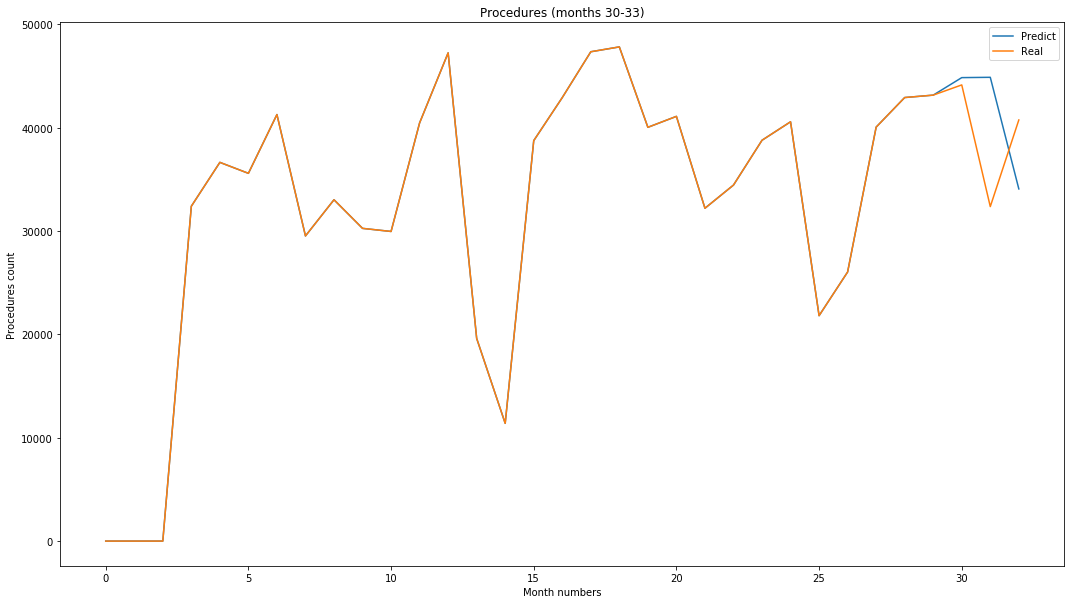

In [29]:

plt.plot(predict_ProcRF4)
plt.plot(ProcRF4)
plt.title('Procedures (months 30-33)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [30]:
%%time
mean_errorGB4 = []
total_errorGB4 = []
ProcGB4 = copy.copy(procedures)
predict_ProcGB4 = copy.copy(procedures)
for Month in range(30,33):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    #print('Month %d - Error %.5f' % (Month, error))
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB4.append(error)
    total_errorGB4.append(abs_error)
    ProcGB4.append(total_yts)
    predict_ProcGB4.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB4))

Month 30 - Error 0.59214, Real Total 44141.0 - Predict Total 40895.2, Abs Error 3245.8
Month 31 - Error 0.74777, Real Total 32367.0 - Predict Total 40680.1, Abs Error 8313.1
Month 32 - Error 0.67470, Real Total 40749.0 - Predict Total 26049.1, Abs Error 14699.9
Mean Error = 0.67153
Mean Abs Error = 8752.91901
Wall time: 3.71 s


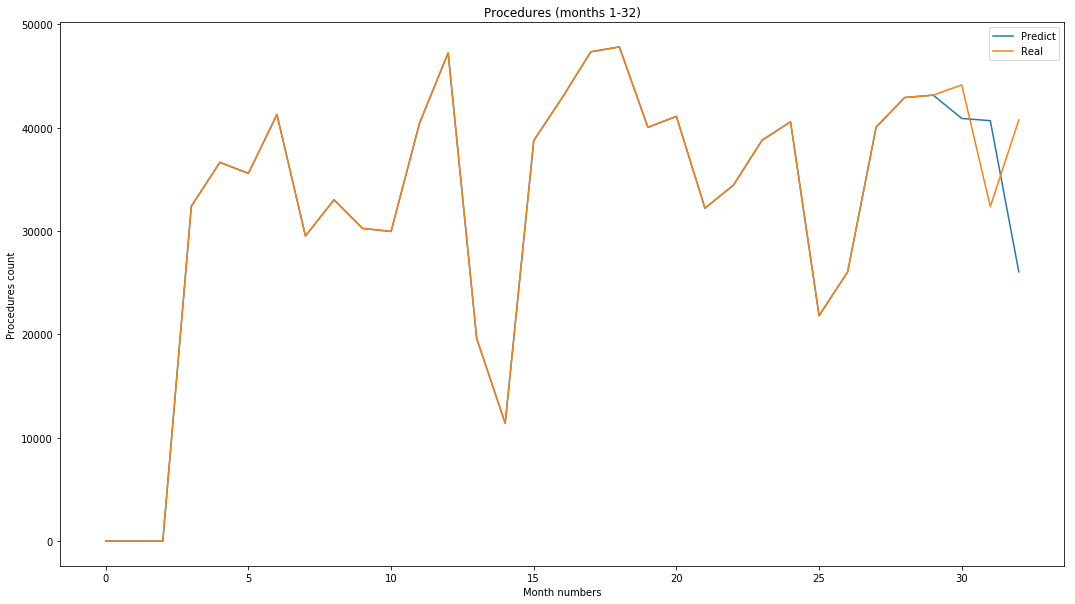

In [31]:

plt.plot(predict_ProcGB4)
plt.plot(ProcGB4)
plt.title('Procedures (months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [32]:
%%time
melt12 = melt.copy()
melt12['Last_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift()
melt12['Last_Month_Diff'] = melt12.groupby(['Total29'])['Last_Month_Proc'].diff()
melt12['Last-1_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(2)
melt12['Last-1_Month_Diff'] = melt12.groupby(['Total29'])['Last-1_Month_Proc'].diff()
melt12['Last-2_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-2_Month_Diff'] = melt12.groupby(['Total29'])['Last-2_Month_Proc'].diff()
melt12['Last-3_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-3_Month_Diff'] = melt12.groupby(['Total29'])['Last-3_Month_Proc'].diff()
melt12['Last-4_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-4_Month_Diff'] = melt12.groupby(['Total29'])['Last-4_Month_Proc'].diff()
melt12['Last-5_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-5_Month_Diff'] = melt12.groupby(['Total29'])['Last-5_Month_Proc'].diff()
melt12['Last-6_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-6_Month_Diff'] = melt12.groupby(['Total29'])['Last-6_Month_Proc'].diff()
melt12['Last-7_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-7_Month_Diff'] = melt12.groupby(['Total29'])['Last-7_Month_Proc'].diff()
melt12['Last-8_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-8_Month_Diff'] = melt12.groupby(['Total29'])['Last-8_Month_Proc'].diff()
melt12['Last-9_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-9_Month_Diff'] = melt12.groupby(['Total29'])['Last-9_Month_Proc'].diff()
melt12['Last-10_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-10_Month_Diff'] = melt12.groupby(['Total29'])['Last-10_Month_Proc'].diff()
melt12['Last-11_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(2)
melt12['Last-11_Month_Diff'] = melt12.groupby(['Total29'])['Last-11_Month_Proc'].diff()
melt12['Last-12_Month_Proc'] = melt12.groupby(['Total29'])['Proc'].shift(3)
melt12['Last-12_Month_Diff'] = melt12.groupby(['Total29'])['Last-12_Month_Proc'].diff()
melt12 = melt12.dropna()
melt12.head()

Wall time: 1.2 s


In [33]:
%%time
mean_errorRF12 = []
total_errorRF12 = []
ProcRF12 = copy.copy(procedures)
predict_ProcRF12 = copy.copy(procedures)
for Month in range(30, 33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF12.append(error)
    total_errorRF12.append(abs_error)
    ProcRF12.append(total_yts)
    predict_ProcRF12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF12))

Month 30 - Error 0.64775, Real Total 44141.0 - Predict Total 44778.1, Abs Error 637.1
Month 31 - Error 0.86811, Real Total 32367.0 - Predict Total 44910.8, Abs Error 12543.8
Month 32 - Error 0.66026, Real Total 40749.0 - Predict Total 34094.7, Abs Error 6654.3
Mean Error = 0.72537
Mean Abs Error = 6611.70800
Wall time: 2min 56s


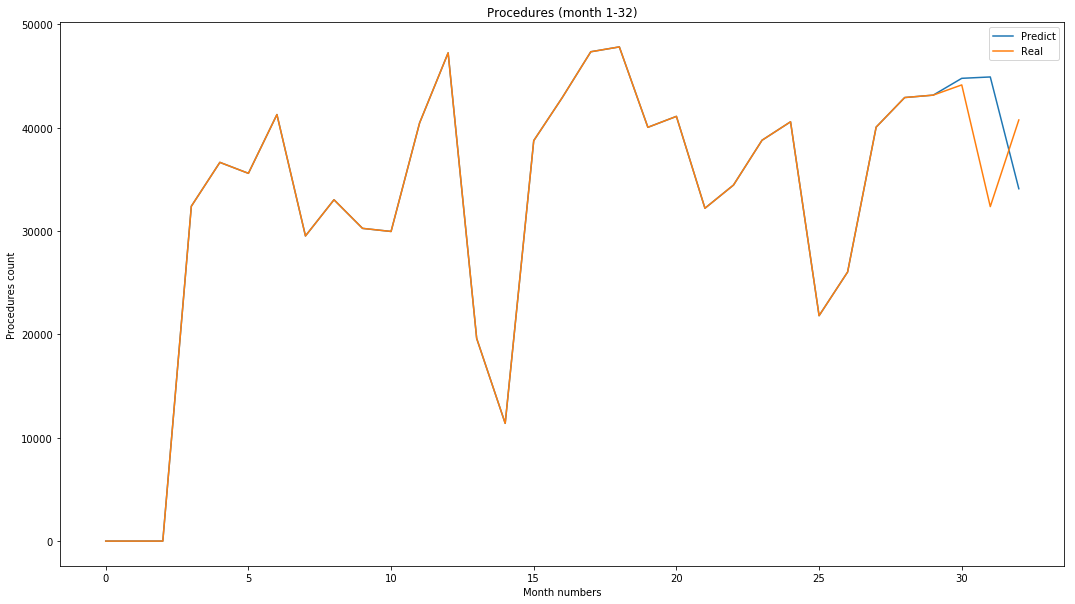

In [34]:

plt.plot(predict_ProcRF12)
plt.plot(ProcRF12)
plt.title('Procedures (month 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [35]:
%%time
mean_errorGB12 = []
total_errorGB12 = []
ProcGB12 = copy.copy(procedures)
predict_ProcGB12 = copy.copy(procedures)
for Month in range(30,33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB12.append(error)
    total_errorGB12.append(abs_error)
    ProcGB12.append(total_yts)
    predict_ProcGB12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB12))

Month 30 - Error 0.59214, Real Total 44141.0 - Predict Total 40895.2, Abs Error 3245.8
Month 31 - Error 0.74777, Real Total 32367.0 - Predict Total 40680.1, Abs Error 8313.1
Month 32 - Error 0.67470, Real Total 40749.0 - Predict Total 26049.1, Abs Error 14699.9
Mean Error = 0.67153
Mean Abs Error = 8752.91901
Wall time: 7.53 s


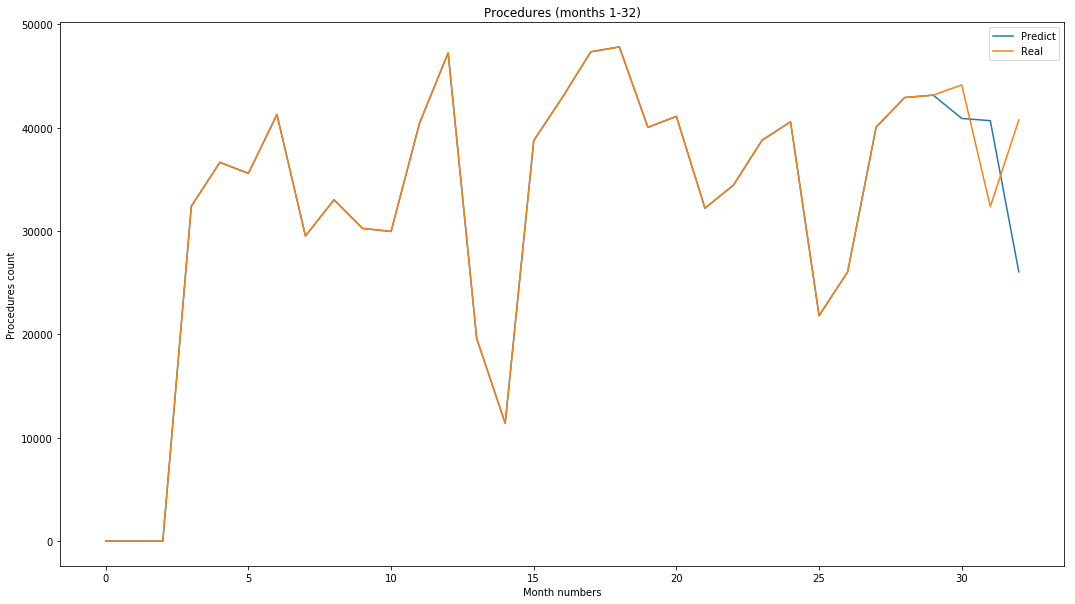

In [36]:

plt.plot(predict_ProcGB12)
plt.plot(ProcGB12)
plt.title('Procedures (months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [37]:
%%time
mean_errorLR12 = []
total_errorLR12 = []
ProcLR12 = copy.copy(procedures)
predict_ProcLR12 = copy.copy(procedures)
for Month in range(30,33):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorLR12.append(error)
    total_errorLR12.append(abs_error)
    ProcLR12.append(total_yts)
    predict_ProcLR12.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error = %.5f' % np.mean(total_errorLR12))

Month 30 - Error 0.86094, Real Total 44141.0 - Predict Total 40797.0, Abs Error 3344.0
Month 31 - Error 1.07681, Real Total 32367.0 - Predict Total 42877.4, Abs Error 10510.4
Month 32 - Error 0.90415, Real Total 40749.0 - Predict Total 33906.4, Abs Error 6842.6
Mean Error = 0.94730
Mean Abs Error = 6898.98130
Wall time: 92.7 ms


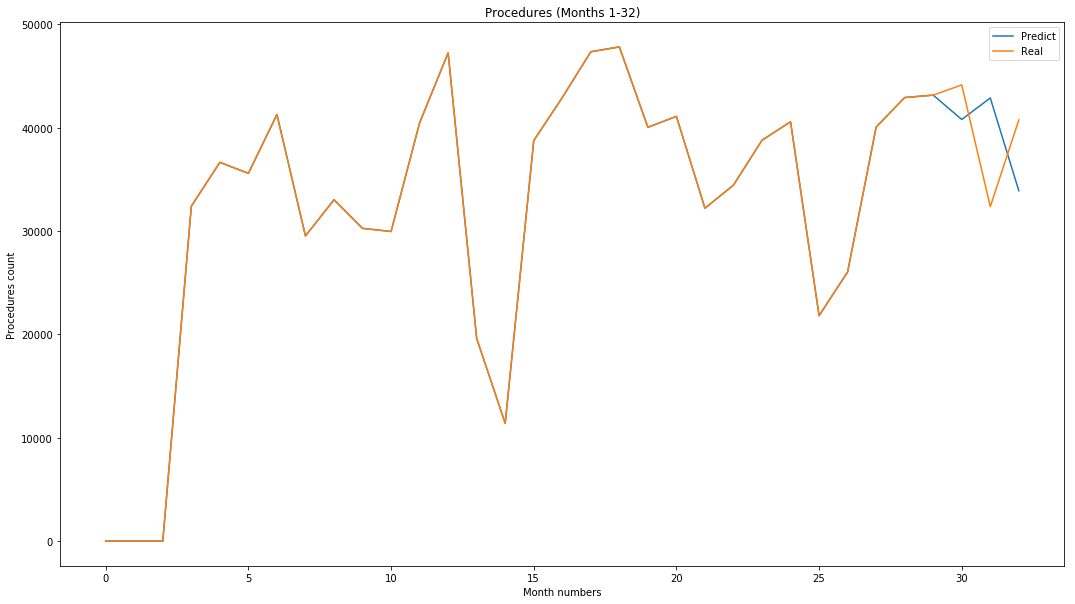

In [38]:

plt.plot(predict_ProcLR12)
plt.plot(ProcLR12)
plt.title('Procedures (Months 1-32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

C:\Users\solod\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


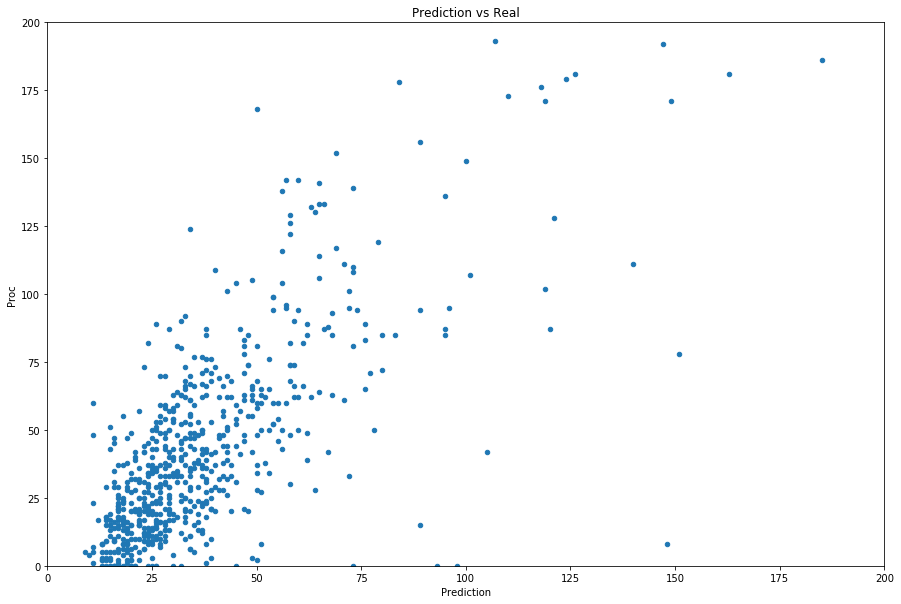

In [49]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,200), xlim=(0,200))

In [40]:
%%time
melt24 = melt.copy()
melt24['Last_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift()
melt24['Last_Month_Diff'] = melt24.groupby(['Total29'])['Last_Month_Proc'].diff()
melt24['Last-1_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(2)
melt24['Last-1_Month_Diff'] = melt24.groupby(['Total29'])['Last-1_Month_Proc'].diff()
melt24['Last-2_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-2_Month_Diff'] = melt24.groupby(['Total29'])['Last-2_Month_Proc'].diff()
melt24['Last-3_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-3_Month_Diff'] = melt24.groupby(['Total29'])['Last-3_Month_Proc'].diff()
melt24['Last-4_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-4_Month_Diff'] = melt24.groupby(['Total29'])['Last-4_Month_Proc'].diff()
melt24['Last-5_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-5_Month_Diff'] = melt24.groupby(['Total29'])['Last-5_Month_Proc'].diff()
melt24['Last-6_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-6_Month_Diff'] = melt24.groupby(['Total29'])['Last-6_Month_Proc'].diff()
melt24['Last-7_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-7_Month_Diff'] = melt24.groupby(['Total29'])['Last-7_Month_Proc'].diff()
melt24['Last-8_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-8_Month_Diff'] = melt24.groupby(['Total29'])['Last-8_Month_Proc'].diff()
melt24['Last-9_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-9_Month_Diff'] = melt24.groupby(['Total29'])['Last-9_Month_Proc'].diff()
melt24['Last-10_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-10_Month_Diff'] = melt24.groupby(['Total29'])['Last-10_Month_Proc'].diff()
melt24['Last-11_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(2)
melt24['Last-11_Month_Diff'] = melt24.groupby(['Total29'])['Last-11_Month_Proc'].diff()
melt24['Last-12_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-12_Month_Diff'] = melt24.groupby(['Total29'])['Last-12_Month_Proc'].diff()
melt24['Last-13_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-13_Month_Diff'] = melt24.groupby(['Total29'])['Last-13_Month_Proc'].diff()
melt24['Last-14_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-14_Month_Diff'] = melt24.groupby(['Total29'])['Last-14_Month_Proc'].diff()
melt24['Last-15_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-15_Month_Diff'] = melt24.groupby(['Total29'])['Last-15_Month_Proc'].diff()
melt24['Last-16_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-16_Month_Diff'] = melt24.groupby(['Total29'])['Last-16_Month_Proc'].diff()
melt24['Last-17_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-17_Month_Diff'] = melt24.groupby(['Total29'])['Last-17_Month_Proc'].diff()
melt24['Last-18_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-18_Month_Diff'] = melt24.groupby(['Total29'])['Last-18_Month_Proc'].diff()
melt24['Last-19_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-19_Month_Diff'] = melt24.groupby(['Total29'])['Last-19_Month_Proc'].diff()
melt24['Last-20_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-20_Month_Diff'] = melt24.groupby(['Total29'])['Last-20_Month_Proc'].diff()
melt24['Last-21_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(2)
melt24['Last-21_Month_Diff'] = melt24.groupby(['Total29'])['Last-21_Month_Proc'].diff()
melt24['Last-22_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-22_Month_Diff'] = melt24.groupby(['Total29'])['Last-22_Month_Proc'].diff()
melt24['Last-23_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24['Last-23_Month_Diff'] = melt24.groupby(['Total29'])['Last-23_Month_Proc'].diff()
melt24['Last-24_Month_Proc'] = melt24.groupby(['Total29'])['Proc'].shift(3)
melt24 = melt24.dropna()
melt24.head()

Wall time: 2.3 s


In [41]:
%%time
mean_errorRF24 = []
total_errorRF24 = []
ProcRF24 = copy.copy(procedures)
predict_ProcRF24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorRF24.append(error)
    total_errorRF24.append(abs_error)
    ProcRF24.append(total_yts)
    predict_ProcRF24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF24))

Month 30 - Error 0.64752, Real Total 44141.0 - Predict Total 44759.9, Abs Error 618.9
Month 31 - Error 0.86717, Real Total 32367.0 - Predict Total 44903.3, Abs Error 12536.3
Month 32 - Error 0.65972, Real Total 40749.0 - Predict Total 34091.6, Abs Error 6657.4
Mean Error = 0.72481
Mean Abs Error = 6604.21400
Wall time: 5min 27s


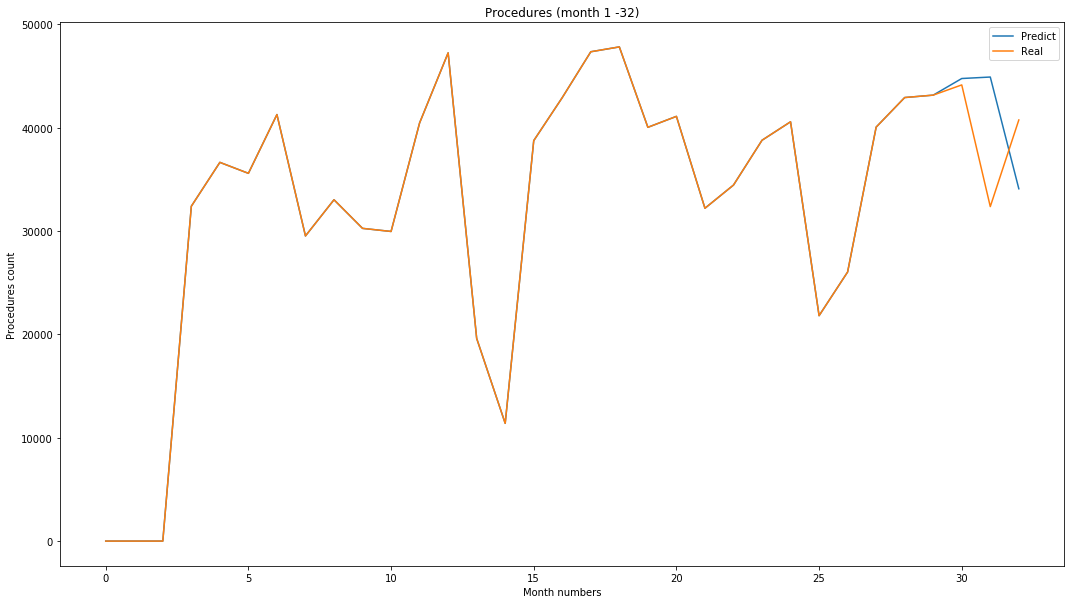

In [42]:

plt.plot(predict_ProcRF24)
plt.plot(ProcRF24)
plt.title('Procedures (month 1 -32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

In [43]:
%%time
mean_errorGB24 = []
total_errorGB24 = []
ProcGB24 = copy.copy(procedures)
predict_ProcGB24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    
    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorGB24.append(error)
    total_errorGB24.append(abs_error)
    ProcGB24.append(total_yts)
    predict_ProcGB24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error = %.5f' % np.mean(total_errorGB24))

Month 30 - Error 0.59214, Real Total 44141.0 - Predict Total 40895.2, Abs Error 3245.8
Month 31 - Error 0.74777, Real Total 32367.0 - Predict Total 40680.1, Abs Error 8313.1
Month 32 - Error 0.67470, Real Total 40749.0 - Predict Total 26049.1, Abs Error 14699.9
Mean Error = 0.67153
Mean Abs Error = 8752.91901
Wall time: 14.5 s


In [45]:
%%time
mean_errorLR24 = []
total_errorLR24 = []
ProcLR24 = copy.copy(procedures)
predict_ProcLR24 = copy.copy(procedures)
for Month in range(30,33):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f' % (Month, error, total_yts, total_p, abs_error))
    mean_errorLR24.append(error)
    total_errorLR24.append(abs_error)
    ProcLR24.append(total_yts)
    predict_ProcLR24.append(total_p)
print('Mean Error = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error = %.5f' % np.mean(total_errorLR24))

Month 30 - Error 0.86094, Real Total 44141.0 - Predict Total 40797.0, Abs Error 3344.0
Month 31 - Error 1.07681, Real Total 32367.0 - Predict Total 42877.4, Abs Error 10510.4
Month 32 - Error 0.90415, Real Total 40749.0 - Predict Total 33906.4, Abs Error 6842.6
Mean Error = 0.94730
Mean Abs Error = 6898.98130
Wall time: 146 ms


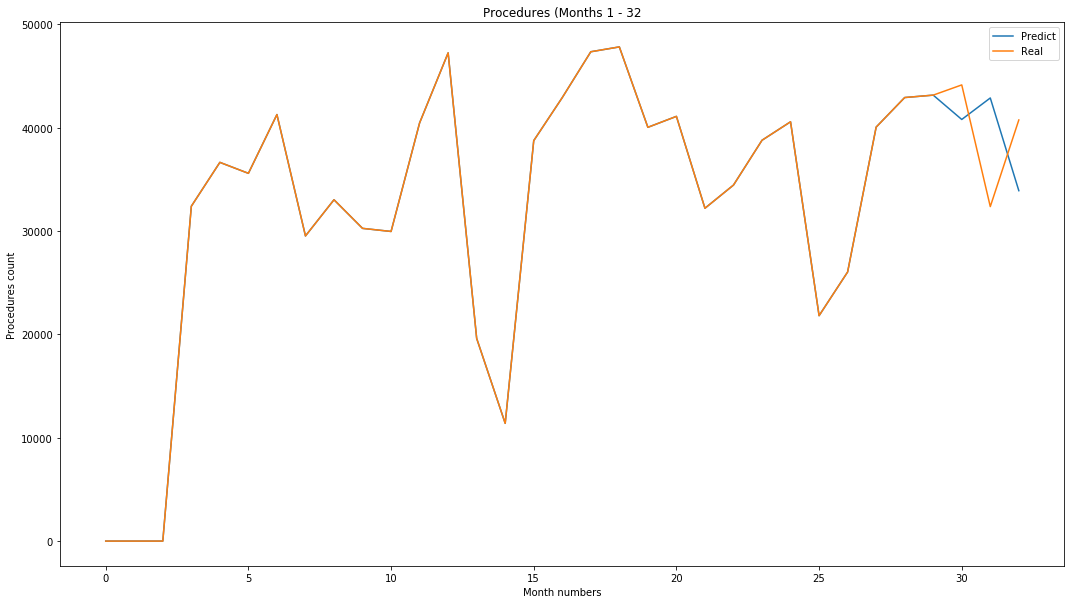

In [46]:

plt.plot(predict_ProcLR24)
plt.plot(ProcLR24)
plt.title('Procedures (Months 1 - 32')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

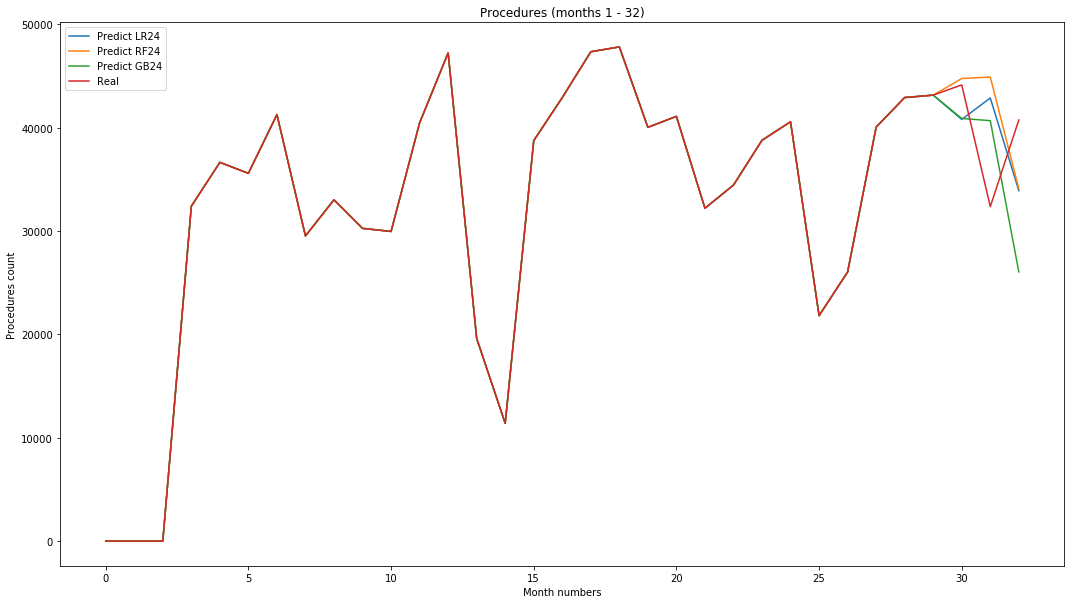

In [47]:
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(ProcGB24)

plt.title('Procedures (months 1 - 32)')
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict LR24', 'Predict RF24', 'Predict GB24', 'Real'))

In [50]:
print('Mean Error baseline = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error baseline = %.5f' % np.mean(total_errorB))
print('Mean Error LR2 = %.5f' % np.mean(mean_error2))
print('Mean Abs Error LR2 = %.5f' % np.mean(total_error2))
print('Mean Error RF2 = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error RF2 = %.5f' % np.mean(total_errorRF2))
print('Mean Error RF3 = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error RF3 = %.5f' % np.mean(total_errorRF3))
print('Mean Error RF4 = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error RF4 = %.5f' % np.mean(total_errorRF4))
print('Mean Error GB4 = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error GB4 = %.5f' % np.mean(total_errorGB4))
print('Mean Error LR12 = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error LR12 = %.5f' % np.mean(total_errorLR12))
print('Mean Error RF12 = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error RF12 = %.5f' % np.mean(total_errorRF12))
print('Mean Error GB12 = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error GB12 = %.5f' % np.mean(total_errorGB12))
print('Mean Error LR24 = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error LR24 = %.5f' % np.mean(total_errorLR24))
print('Mean Error RF24 = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error RF24 = %.5f' % np.mean(total_errorRF24))
print('Mean Error GB24 = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error GB24 = %.5f' % np.mean(total_errorGB24))

Mean Error baseline = 0.73388
Mean Abs Error baseline = 7048.33333
Mean Error LR2 = 0.96789
Mean Abs Error LR2 = 6778.48225
Mean Error RF2 = 0.72663
Mean Abs Error RF2 = 6478.37033
Mean Error RF3 = 0.72899
Mean Abs Error RF3 = 6603.06333
Mean Error RF4 = 0.72314
Mean Abs Error RF4 = 6629.05267
Mean Error GB4 = 0.67153
Mean Abs Error GB4 = 8752.91901
Mean Error LR12 = 0.94730
Mean Abs Error LR12 = 6898.98130
Mean Error RF12 = 0.72537
Mean Abs Error RF12 = 6611.70800
Mean Error GB12 = 0.67153
Mean Abs Error GB12 = 8752.91901
Mean Error LR24 = 0.94730
Mean Abs Error LR24 = 6898.98130
Mean Error RF24 = 0.72481
Mean Abs Error RF24 = 6604.21400
Mean Error GB24 = 0.67153
Mean Abs Error GB24 = 8752.91901
